In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model
import keras


data = pd.read_csv("C:\\multi_final\\data\\2022년_latest.csv",index_col=[0])

In [14]:
grouped = data.groupby('ID')
dfs = [group for _, group in grouped]

In [15]:
# 특정정류소 선택 1124
df=dfs[4]

In [16]:
df.index=pd.to_datetime(df.index)
df['시'] = df.index.hour
df['요일'] = df.index.weekday

In [17]:
# 기존 거치대수 저장용
original_y = df['y'].values

# 날짜
dates = pd.to_datetime(df.index)

In [18]:
df

,ID,temperature,rain,precipitation,population,is_weekend,y,시,요일
datetime,,,,,,,,,
2022-01-01 00:00:00,1166,-4.4,0.0,0.0,36035.8543,1,16,0,5
2022-01-01 01:00:00,1166,-2.5,0.0,0.0,35888.4102,1,16,1,5
2022-01-01 02:00:00,1166,-1.6,0.0,0.0,36128.6065,1,17,2,5
2022-01-01 03:00:00,1166,0.2,0.0,0.0,35962.9602,1,17,3,5
2022-01-01 04:00:00,1166,0.6,0.0,0.0,35916.8179,1,18,4,5
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,1166,0.8,0.0,0.0,40997.9744,1,4,19,5
2022-12-31 20:00:00,1166,-0.2,0.0,0.0,40200.3546,1,1,20,5
2022-12-31 21:00:00,1166,-0.5,0.0,0.0,38229.2212,1,3,21,5


In [19]:
# 거치대수를 두번째열로 바꿈

# 첫 번째 열의 이름을 가져옵니다. (예제에서는 'first_col'이라고 가정)
first_col = df.columns[1]

# 'y' 열과 첫 번째 열을 제외한 나머지 열의 이름을 가져옵니다.
other_cols = df.columns.drop(['y', first_col])

# 첫 번째 열, 'y' 열, 그리고 나머지 열을 순서대로 배치하여 새로운 순서를 생성합니다.
new_cols = [first_col, 'y'] + list(other_cols)

# 새로운 열 순서를 적용합니다.
df = df[new_cols]

# 결과를 확인합니다.
print(df.head())

                     temperature   y    ID  rain  precipitation  population  \
datetime                                                                      
2022-01-01 00:00:00         -4.4  16  1166   0.0            0.0  36035.8543   
2022-01-01 01:00:00         -2.5  16  1166   0.0            0.0  35888.4102   
2022-01-01 02:00:00         -1.6  17  1166   0.0            0.0  36128.6065   
2022-01-01 03:00:00          0.2  17  1166   0.0            0.0  35962.9602   
2022-01-01 04:00:00          0.6  18  1166   0.0            0.0  35916.8179   

                     is_weekend  시  요일  
datetime                                
2022-01-01 00:00:00           1  0   5  
2022-01-01 01:00:00           1  1   5  
2022-01-01 02:00:00           1  2   5  
2022-01-01 03:00:00           1  3   5  
2022-01-01 04:00:00           1  4   5  


In [20]:
df

,temperature,y,ID,rain,precipitation,population,is_weekend,시,요일
datetime,,,,,,,,,
2022-01-01 00:00:00,-4.4,16,1166,0.0,0.0,36035.8543,1,0,5
2022-01-01 01:00:00,-2.5,16,1166,0.0,0.0,35888.4102,1,1,5
2022-01-01 02:00:00,-1.6,17,1166,0.0,0.0,36128.6065,1,2,5
2022-01-01 03:00:00,0.2,17,1166,0.0,0.0,35962.9602,1,3,5
2022-01-01 04:00:00,0.6,18,1166,0.0,0.0,35916.8179,1,4,5
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.8,4,1166,0.0,0.0,40997.9744,1,19,5
2022-12-31 20:00:00,-0.2,1,1166,0.0,0.0,40200.3546,1,20,5
2022-12-31 21:00:00,-0.5,3,1166,0.0,0.0,38229.2212,1,21,5


In [21]:
import os

save_dir = './save_weights_2'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 168, 64)        │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Loaded model from disk
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
(619, 1) (619, 1)
(619,)
(619,)


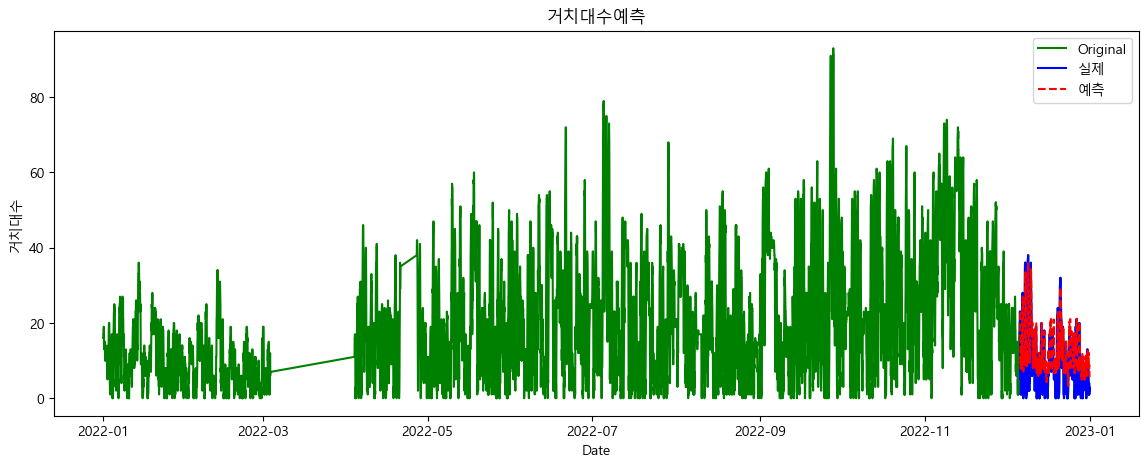

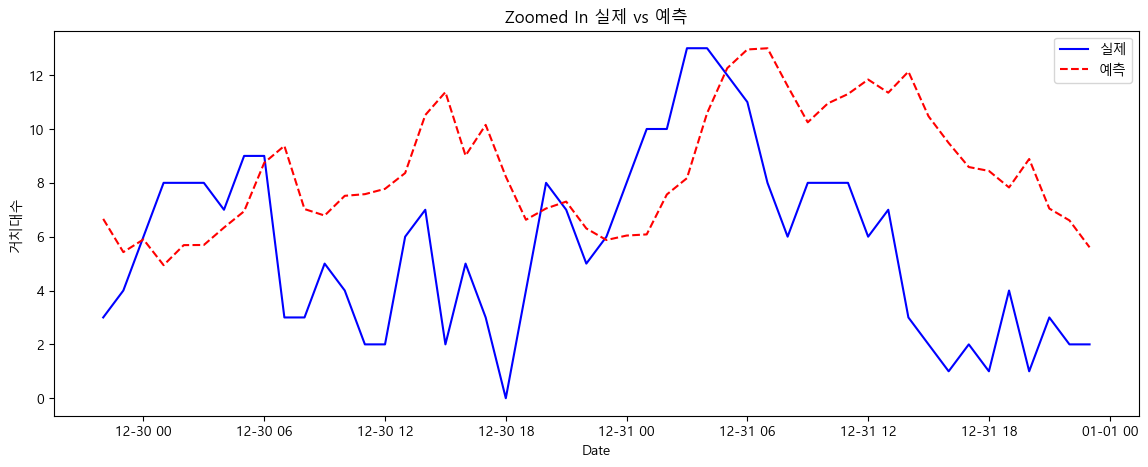

In [22]:
# 변수선택
cols = list(df)[1:9]

# new dataframe with only training data - 8 columns
df = df[cols].astype(float)

# 정규화
scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = scaler.transform(df)

# train,test분리
n_train = int(0.9*df_scaled.shape[0])
train_data_scaled = df_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = df_scaled[n_train:]
test_dates = dates[n_train:]


# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 168   # sequence length 168시간=1주일
input_dim = 8 

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)


# LSTM model with dropout
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout 추가, 여기서 0.2는 dropout 비율을 의미
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))  # 두 번째 LSTM 레이어 후에도 Dropout 추가
model.add(Dense(trainY.shape[1]))

model.summary()

# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

# Try to load weights
try:
    model = keras.models.load_model('./save_weights_2/my_model_2.keras')  # 변경된 경로와 모델 이름
    print("Loaded model from disk")
except:
    print("No model found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32,
                        validation_split=0.1, verbose=1)
    # Save the entire model after training to the new path
    save_model(model, './save_weights_2/my_model_2.keras')  # 변경된 경로와 모델 이름

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()



# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)

# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
print(y_pred.shape)

# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)

# plotting
plt.figure(figsize=(14, 5))

# plot 기존거치대수
plt.plot(dates, original_y, color='green', label='Original')

# plot actual vs predicted
plt.rc('font', family="Malgun Gothic")
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='실제')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='예측')
plt.xlabel('Date')
plt.ylabel('거치대수')
plt.title('거치대수예측')
plt.legend()
plt.show()

# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='실제')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='예측')

plt.xlabel('Date')
plt.ylabel('거치대수')
plt.title('Zoomed In 실제 vs 예측')
plt.legend()
plt.show()

Mean Absolute Error (MAE): 4.6986
Mean Squared Error (MSE): 30.9236
Root Mean Squared Error (RMSE): 5.5609
R-squared (R2 Score): 0.5749


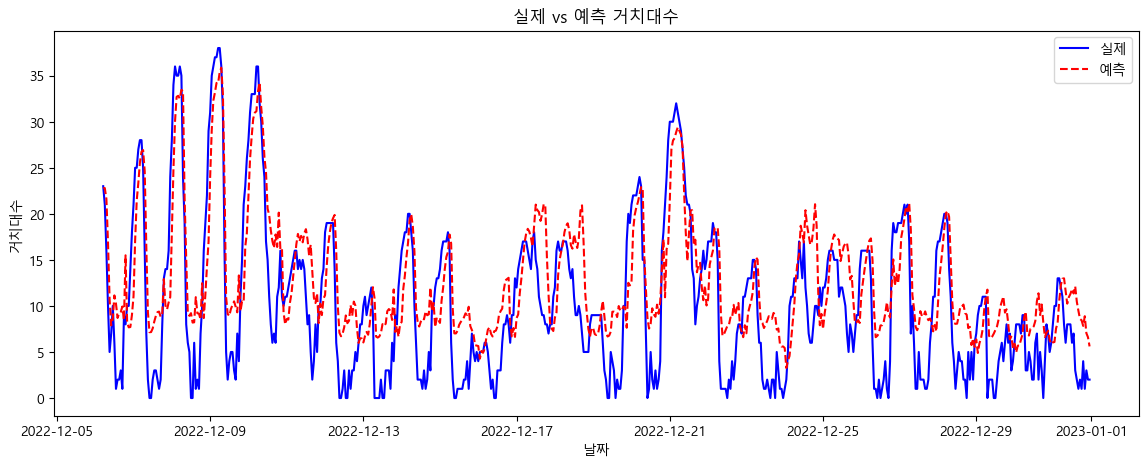

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 실제 값과 예측 값을 기반으로 MAE, MSE, RMSE 계산
mae = mean_absolute_error(testY_original, y_pred)
mse = mean_squared_error(testY_original, y_pred)
rmse = np.sqrt(mse)
# R2 score 계산
r2 = r2_score(testY_original, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2 Score): {r2:.4f}')

# 실제 값과 예측 값의 비교 시각화
plt.figure(figsize=(14, 5))
plt.rc('font', family="Malgun Gothic")
plt.plot(test_dates[seq_len:], testY_original, label='실제', color='blue')
plt.plot(test_dates[seq_len:], y_pred, label='예측', color='red', linestyle='--')
plt.xlabel('날짜')
plt.ylabel('거치대수')
plt.title('실제 vs 예측 거치대수')
plt.legend()
plt.show()


In [24]:
try:
    model = keras.models.load_model('./save_weights_2/my_model_2.keras')
    print("Loaded model from disk")
except Exception as e:
    print("No model found, training model from scratch. Error: ", e)
    # 나머지 코드...


Loaded model from disk
